<h1 align=center><font size = 7>IBM Data Science - NTL</font></h1>
<h1 align=center><font size = 6>Capstone Project - The Battle of Neighborhoods</font></h1>
<h1 align=center><font size = 5>Optimal Location for Asian Restaurant in London</font></h1>

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1.  Introduction.

2.  Data.

3.  Methodology.

4.  Results.
    
4.  Discussion.

5.  Conclusion 
    </font>
    </div>

## 1. Introduction

London is cosidered one of the largest cities in England and the United Kingdom. Opening a new restaurant in a capital city like London can be challenging and complicated task. One may need to make huge investment but, before making such investments you want to be certain about the place to enjoy maximum customers. London has a large population of people from different foreign countries from Asia, Australia, America and Middle east.

The 2011 census recorded that 2,998,264 people or 36.7% of London's population are foreign-born making London the city with the second largest immigrant population, behind New York City. Ethnicity is one of the many factors that play a role in food choices so factors such as the kind of demographics who live there can give investors a good start off. In this project, we aim to find an optimal location for a new Asian restaurant in London through analysis of demographics of London to choose best borough and explore neighbourhoods of that borough.

## 2. Data

To solve the problem, data showing demographical representation of London, list of boroughs and neighbourhood location and its geographical coordinates will be used in the analysis.

1.	To demonstrate the Ethnic make-up of London(2011 Census). The data is scraped from Wikipedia:        https://en.wikipedia.org/wiki/Demography_of_London
2.	The List of all boroughs of London is scraped from the Wikipedia page: https://en.wikipedia.org/wiki/London_boroughs
3.	Demography of London giving more details about Racial make-up of London boroughs (2011 Census) was obtained by scraping web     page: https://en.wikipedia.org/wiki/Demography_of_London
4.	Neighbourhoods of Newham was obtained by web scraping the list available on the page                       https://en.wikipedia.org/wiki/London_Borough_of_Newham#Districts
5.	Geographical co-ordinates of Boroughs of London and Neighbourhoods of Newham was obtained using Geopy Library (Geocoding       Web Services).
6.	Foursquare location data (Foursquare API) used to explore neighbourhoods of Newham and find optimal location for opening an     Asian restaurant within defined radius of each neighbourhood.

In [1]:
# Import necessarly libraries
import numpy as np
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# library to handle requests
import requests 

import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# this module helps in web scrapping.
from bs4 import BeautifulSoup
import re

#Import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

! pip install folium
import folium # map rendering library

!pip install geocoder
import geocoder

print('Libraries imported.')

Solving environment: ...working... done

# All requested packages already installed.

Libraries imported.


### Analyzing ethnic make-up of London to discover our target customer's population in London  

In [2]:
ethinic_link = "https://en.wikipedia.org/wiki/Demography_of_London"
tables = pd.read_html(ethinic_link, match="Ethnic make-up of Greater London")
print("There are : ", len(tables)," tables")

There are :  1  tables


In [3]:
london_ethnic_fig = pd.DataFrame(tables[0])
london_ethnic_fig.head()

Ethnic Group    1991[6]            2001[7]  \
                              Ethnic Group     Number       %     Number   
0                   White: British[Note 1]        NaN     NaN  4287861.0   
1                             White: Irish   256470.0   3.83%   220488.0   
2  White: Gypsy or Irish Traveller[Note 2]        NaN     NaN        NaN   
3                     White: Other[Note 1]        NaN     NaN   594854.0   
4                             White: Total  5333580.0  79.80%  5103203.0   

           2011[8]         Change 2001–2011  
        %   Number       %                %  
0  59.79%  3669284  44.89%           14.43%  
1   3.07%   175974   2.15%           20.19%  
2     NaN     8196   0.10%              NaN  
3   8.29%  1033981  12.65%           73.82%  
4  71.15%  4887435  59.79%            4.23%

In [4]:
# Check number of variables and names
print("There are", len(london_ethnic_fig.columns), "columns in the dataframe")
print(london_ethnic_fig.columns)

There are 8 columns in the dataframe
MultiIndex([(    'Ethnic Group', 'Ethnic Group'),
            (         '1991[6]',       'Number'),
            (         '1991[6]',            '%'),
            (         '2001[7]',       'Number'),
            (         '2001[7]',            '%'),
            (         '2011[8]',       'Number'),
            (         '2011[8]',            '%'),
            ('Change 2001–2011',            '%')],
           )


In [5]:
# flatten index and convert it into single index column dataframe
london_ethnic_fig.columns = london_ethnic_fig.columns.to_flat_index()
london_ethnic_fig.head()

,"(Ethnic Group, Ethnic Group)","(1991[6], Number)","(1991[6], %)","(2001[7], Number)","(2001[7], %)","(2011[8], Number)","(2011[8], %)","(Change 2001–2011, %)"
0,White: British[Note 1],NaN,NaN,4287861.0,59.79%,3669284,44.89%,14.43%
1,White: Irish,256470.0,3.83%,220488.0,3.07%,175974,2.15%,20.19%
2,White: Gypsy or Irish Traveller[Note 2],NaN,NaN,NaN,NaN,8196,0.10%,NaN
3,White: Other[Note 1],NaN,NaN,594854.0,8.29%,1033981,12.65%,73.82%
4,White: Total,5333580.0,79.80%,5103203.0,71.15%,4887435,59.79%,4.23%


In [6]:
# Change column names for clarity
london_ethnic_fig = london_ethnic_fig.rename(columns={('Ethnic Group', 'Ethnic Group'): 'Ethnic Group'})
london_ethnic_fig = london_ethnic_fig.rename(columns={('1991[6]', 'Number'): '1991 Census[Number]'})
london_ethnic_fig = london_ethnic_fig.rename(columns={('1991[6]', '%'): '1991 Census[%]'})
london_ethnic_fig = london_ethnic_fig.rename(columns={('2001[7]', 'Number'): '2001 Census[Number]'})
london_ethnic_fig = london_ethnic_fig.rename(columns={('2001[7]', '%'): '2001 Census[%]'})
london_ethnic_fig = london_ethnic_fig.rename(columns={('2011[8]', 'Number'): '2011 Census[Number]'})
london_ethnic_fig = london_ethnic_fig.rename(columns={('2011[8]', '%'):'2011 Census[%]'})
london_ethnic_fig = london_ethnic_fig.rename(columns={('Change 2001–2011', '%'):'Change 2001-2011'})

# Checking whether all column names are string
print(london_ethnic_fig.columns)
all(isinstance(column, str) for column in london_ethnic_fig.columns)

Index(['Ethnic Group', '1991 Census[Number]', '1991 Census[%]',
       '2001 Census[Number]', '2001 Census[%]', '2011 Census[Number]',
       '2011 Census[%]', 'Change 2001-2011'],
      dtype='object')


True

In [7]:
# checking datatypes of each columns
london_ethnic_fig.dtypes

Ethnic Group            object
1991 Census[Number]    float64
1991 Census[%]          object
2001 Census[Number]    float64
2001 Census[%]          object
2011 Census[Number]      int64
2011 Census[%]          object
Change 2001-2011        object
dtype: object

In [8]:
# Remove columns which are not required 
london_ethnic_fig = london_ethnic_fig.drop(['Change 2001-2011'], axis=1)

# Remove % sign from dataframe
london_ethnic_fig = london_ethnic_fig.replace({'%':''}, regex=True)

# As there are few "NaN" values for majorly for "1991-2000" and "2001-2010" but for analysis I am more interested in "2011-2020"
# So I am directly replacing NaN with 0
london_ethnic_fig = london_ethnic_fig.fillna(0)

# Remove unnecessory character from "Ethnic Group column"
london_ethnic_fig['Ethnic Group'] = london_ethnic_fig['Ethnic Group'].map(lambda x: x.rstrip(']').rstrip('123').rstrip('Note ').rstrip('['))

# Change columns to float 
cols = ['1991 Census[%]', '2001 Census[%]','2011 Census[%]']
london_ethnic_fig[cols] = london_ethnic_fig[cols].apply(pd.to_numeric, errors='coerce', axis=1)

# Change columns to Integer 
london_ethnic_fig[["1991 Census[Number]"]] = london_ethnic_fig[["1991 Census[Number]"]].astype("int")
london_ethnic_fig[["2001 Census[Number]"]] = london_ethnic_fig[["2001 Census[Number]"]].astype("int")
london_ethnic_fig[["2011 Census[Number]"]] = london_ethnic_fig[["2011 Census[Number]"]].astype("int")

In [9]:
# let's populate clean table
london_ethnic_fig

,Ethnic Group,1991 Census[Number],1991 Census[%],2001 Census[Number],2001 Census[%],2011 Census[Number],2011 Census[%]
0,White: British,0,0.00,4287861,59.79,3669284,44.89
1,White: Irish,256470,3.83,220488,3.07,175974,2.15
2,White: Gypsy or Irish Traveller,0,0.00,0,0.00,8196,0.10
3,White: Other,0,0.00,594854,8.29,1033981,12.65
4,White: Total,5333580,79.80,5103203,71.15,4887435,59.79
5,Asian or Asian British: Indian,347091,5.19,436993,6.09,542857,6.64
6,Asian or Asian British: Pakistani,87816,1.31,142749,1.99,223797,2.74
7,Asian or Asian British: Bangladeshi,85738,1.28,153893,2.15,222127,2.72
8,Asian or Asian British: Chinese,56579,0.84,80201,1.12,124250,1.52
9,Asian or Asian British: Other Asian,112807,1.68,133058,1.86,398515,4.88


#### From table above, It is boserved that the second large population is Asian. It is also giving insight  white ethnic group population proportion fell in 2011 census by 11.36% and Asian population is increased by 5.29% so Asian population evidently increasing in London which is a good sign for someone looking to open Asian restaurant.

In [10]:
london_ethnic_fig1 = london_ethnic_fig[london_ethnic_fig['Ethnic Group'].str.contains('Total')]
london_ethnic_fig2 = london_ethnic_fig1[['Ethnic Group','1991 Census[%]','2001 Census[%]','2011 Census[%]']]
london_ethnic_fig2.reset_index(drop=True, inplace=True)
london_ethnic_fig2.set_index('Ethnic Group', inplace=True)
london_ethnic_fig2 = london_ethnic_fig2.drop(['Total'])
london_ethnic_fig2

,1991 Census[%],2001 Census[%],2011 Census[%]
Ethnic Group,,,
White: Total,79.80,71.15,59.79
Asian or Asian British: Total,10.33,13.20,18.49
Black or Black British: Total,8.01,10.92,13.32
Mixed: Total,0.00,3.15,4.96
Other: Total,1.81,1.58,3.44


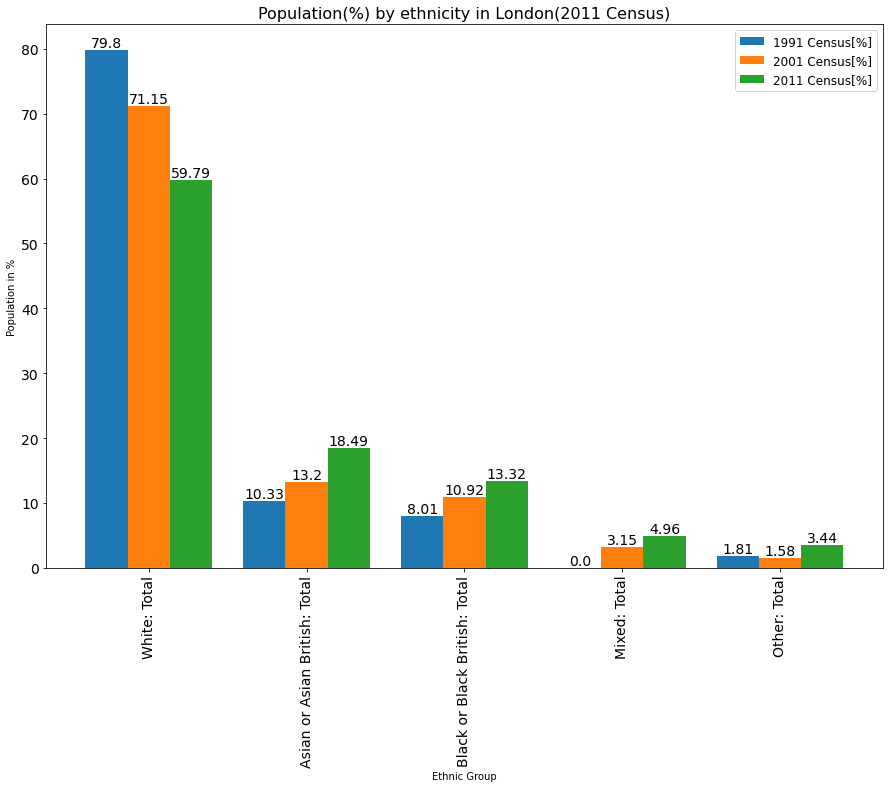

In [11]:
# Show population in %
ax = london_ethnic_fig2.plot(kind='bar',
               figsize= (15, 10),
               width= 0.8,
               fontsize= 14)

ax.set_title("Population(%) by ethnicity in London(2011 Census)", fontsize=16)
ax.set_ylabel('Population in %')
ax.set_xlabel('Ethnic Group')
              
ax.legend(prop=dict(size=12))
for rect in ax.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2
        va = 'top'
        label = y_value

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Vertically shift label by `space`
            xytext= (0,14),
            textcoords="offset points",
            ha='center',                # Horizontally center label
            va=va,                      
            fontsize=14)

plt.show()

### Importing list of boroughs of london which I will get by web scraping wikipedia page

In [12]:
URL = 'https://en.wikipedia.org/wiki/London_boroughs'
response = requests.get(URL)

try:
    response.raise_for_status()
    soup = BeautifulSoup(response.text, 'html.parser')
    
except Exception as exc:
    print('Error while downloading the webpage.. %s' % exc)

In [13]:
# Getting the table containing the borough names
Data = soup.find('table', attrs={'class':"wikitable sortable"})

In [14]:
# Using regex and getting the exact Borough names:

column_name = ['London_Borough',] 
London_df = pd.DataFrame(columns=column_name)

for row in Data.findAll('tr'):
    line_item = row.findAll('td')
    if line_item:
        name1 = line_item[0].text.strip()
        re_obj = re.compile('\[')
        split_obj = re_obj.split(name1)
        borough_name = split_obj[0].strip()
        London_df = London_df.append({'London_Borough': borough_name},
                                        ignore_index=True)

In [15]:
London_df.head()

,London_Borough
0,Camden
1,Greenwich
2,Hackney
3,Hammersmith
4,Islington


In [16]:
# Changing names of couple of boroughs
London_df["London_Borough"].replace({"Hammersmith": "Hammersmith and Fulham", "Barking": "Barking and Dagenham"}, inplace=True)

In [17]:
# Using geopy library to get the latitude and longitude of London Boroughs
Area = list(London_df["London_Borough"])
l = len(Area)
latitudes = []
longitudes = []

for i in range(l):
    locality = Area[i]
    address = locality + ', London'

    geolocator = Nominatim(user_agent="london_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    latitudes.append(latitude)
    longitudes.append(longitude)
    
    print('The geograpical coordinate of {}, London are {}, {}.'.format(Area[i], latitude, longitude))

The geograpical coordinate of Camden, London are 51.5423045, -0.1395604.
The geograpical coordinate of Greenwich, London are 51.4820845, -0.0045417.
The geograpical coordinate of Hackney, London are 51.5432402, -0.0493621.
The geograpical coordinate of Hammersmith and Fulham, London are 51.4920377, -0.2236401.
The geograpical coordinate of Islington, London are 51.5384287, -0.0999051.
The geograpical coordinate of Kensington and Chelsea, London are 51.498480400000005, -0.1990432138025393.
The geograpical coordinate of Lambeth, London are 51.5013012, -0.117287.
The geograpical coordinate of Lewisham, London are 51.4624325, -0.0101331.
The geograpical coordinate of Southwark, London are 51.5029222, -0.103458.
The geograpical coordinate of Tower Hamlets, London are 51.1356795, 1.2978105.
The geograpical coordinate of Wandsworth, London are 51.4570271, -0.1932607.
The geograpical coordinate of Westminster, London are 51.5004439, -0.1265398.
The geograpical coordinate of Barking and Dagenha

In [18]:
London_df.insert(loc = 1, column='latitudes', value=latitudes)
London_df.insert(loc = 2, column='longitudes', value=longitudes)
London_df

,London_Borough,latitudes,longitudes
0,Camden,51.542305,-0.139560
1,Greenwich,51.482084,-0.004542
2,Hackney,51.543240,-0.049362
3,Hammersmith and Fulham,51.492038,-0.223640
4,Islington,51.538429,-0.099905
5,Kensington and Chelsea,51.498480,-0.199043
6,Lambeth,51.501301,-0.117287
7,Lewisham,51.462432,-0.010133
8,Southwark,51.502922,-0.103458
9,Tower Hamlets,51.135680,1.297810


In [19]:
# Referring to the co-ordinates, "Tower Hamlets" seems odd so replaced with correct co-oridnates   
London_df.set_index('London_Borough', inplace=True)
London_df = London_df.drop(['Tower Hamlets'], axis=0)
London_df.reset_index(drop=False, inplace=True)
London_df.loc[31]= ['Tower Hamlets', 51.5166670, -0.0499998]
London_df

,London_Borough,latitudes,longitudes
0,Camden,51.542305,-0.139560
1,Greenwich,51.482084,-0.004542
2,Hackney,51.543240,-0.049362
3,Hammersmith and Fulham,51.492038,-0.223640
4,Islington,51.538429,-0.099905
5,Kensington and Chelsea,51.498480,-0.199043
6,Lambeth,51.501301,-0.117287
7,Lewisham,51.462432,-0.010133
8,Southwark,51.502922,-0.103458
9,Wandsworth,51.457027,-0.193261


### From "demography of London" page let's find more details about Racial make-up of London boroughs (2011 Census)

In [20]:
demo_link = 'https://en.wikipedia.org/wiki/Demography_of_London'
demo_page = requests.get(demo_link)
soup2 = BeautifulSoup(demo_page.content, 'html.parser')
table2 = soup2.find('table', {'class':'wikitable sortable'})

In [21]:
london_demo = pd.read_html(str(table2))
london_demo=pd.DataFrame(london_demo[0])
print(london_demo.shape)
london_demo

(33, 6)


,Local authority,White,Mixed,Asian,Black,Other
0,Barnet,64.1,4.8,18.5,7.7,4.8
1,Barking and Dagenham,58.3,4.2,15.9,20.0,1.6
2,Bexley,81.9,2.3,6.6,8.5,0.8
3,Brent,36.3,5.1,34.1,18.8,5.8
4,Bromley,84.3,3.5,5.2,6.0,0.9
5,Camden,66.3,5.6,16.1,8.2,3.8
6,City of London,78.6,3.9,12.7,2.6,2.1
7,Croydon,55.1,6.6,16.4,20.2,1.8
8,Ealing,49.0,4.5,29.7,10.9,6.0
9,Enfield,61.0,5.5,11.2,17.2,5.1


#### The list of boroughs scraped from wiki page contains 33 borough which includes ""City of London" but in London there are only 32 boroughs(Inner and Outer) so one additional borough appearing is "City of London" which is part of Greater london so I removed row "City of London" from dataframe

In [22]:
london_demo.rename(columns={'Local authority':'London_Borough'}, inplace=True)
london_demo.set_index('London_Borough', inplace=True)
london_demo = london_demo.drop(['City of London'], axis=0)
london_demo.reset_index(drop=False, inplace=True)
print(london_demo.shape)
london_demo.head(7)

(32, 6)


,London_Borough,White,Mixed,Asian,Black,Other
0,Barnet,64.1,4.8,18.5,7.7,4.8
1,Barking and Dagenham,58.3,4.2,15.9,20.0,1.6
2,Bexley,81.9,2.3,6.6,8.5,0.8
3,Brent,36.3,5.1,34.1,18.8,5.8
4,Bromley,84.3,3.5,5.2,6.0,0.9
5,Camden,66.3,5.6,16.1,8.2,3.8
6,Croydon,55.1,6.6,16.4,20.2,1.8


In [23]:
# Taking only necessory column
London_Asian_demo = london_demo[['London_Borough','Asian']]

#Soring by Asian 
London_Asian_demo= London_Asian_demo.sort_values(by='Asian', ascending = False)
London_Asian_demo.reset_index(drop=True, inplace=True)

In [24]:
#Merge Latitude and Longitude columns from London_df
London_Asian_cord = London_Asian_demo.merge(London_df, on=['London_Borough'])
London_Asian_cord

,London_Borough,Asian,latitudes,longitudes
0,Newham,43.5,51.530000,0.029318
1,Harrow,42.6,51.596827,-0.337316
2,Redbridge,41.8,51.576320,0.045410
3,Tower Hamlets,41.1,51.516667,-0.050000
4,Hounslow,34.4,51.468613,-0.361347
5,Brent,34.1,51.563826,-0.275760
6,Ealing,29.7,51.512655,-0.305195
7,Hillingdon,25.3,51.542519,-0.448335
8,Waltham Forest,21.1,51.598169,-0.017837
9,Barnet,18.5,51.653090,-0.200226


In [25]:
#Using Geopy to get geographical co-ordinates of London
address = 'London, England'

geolocator = Nominatim(user_agent="london_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of London, England are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of London, England are 51.5073219, -0.1276474.


In [26]:
# Superimposing Asian population on the map of London
map_london = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, borough, r in zip(London_Asian_cord['latitudes'], London_Asian_cord['longitudes'], 
                                           London_Asian_cord['London_Borough'],London_Asian_cord['Asian']):
    label = borough
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=r/1.5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)  
    
map_london

Above map showing density of Asian ethnic group on the map of London. Newham, Redbridge, Harrow, Hounslow,Tower Hamlets,Brent and Ealing are the having large number of Asian ethnic group population 

Among all boroughs of London, Newham has had largest Asian community from many decades as per 2011 census data presented above. Upon some more research I found that Newham has the largest total population of Asian origin in London, and it is 20th most populous borough of all English districts of United Kingdom. So, through the analysis of demography of London, I narrowed down my search for best borough to Newham..

I will further explore districts of Newham borough to find out optimal location to open Asian restaurants

In [27]:
# Getting list of neighbourhoods/district from wikipedia page into pandas list
district_name = []
borough_info = []

district_details = {}
Newham_link = 'https://en.wikipedia.org/wiki/London_Borough_of_Newham#Districts'
Newham_var = requests.get(Newham_link)
Newham_soup_var = BeautifulSoup(Newham_var.text, 'html.parser')
district_var = Newham_soup_var.find(class_='mw-headline',id='Districts') 

for dist in district_var.find_next('ul').findAll('li'):
    d2 = dist.text.strip()
    dist2 = d2.split('(')[0]
    district_name.append(dist2)
    borough_info.append('Newham')

In [28]:
# USing list to obtain coordinates through Geopy user agent 
latitude = []
longitude = []

for dist in district_name:
    address = '{}, London, United Kingdom'.format(dist)
    geolocator = Nominatim(user_agent="London_agent", timeout=10)
    location = geolocator.geocode(address)
    if location:
        latitude.append(location.latitude)
        longitude.append(location.longitude)
    else:
        latitude.append(np.nan)
        longitude.append(np.nan)

print(district_name, latitude, longitude)

['Beckton', 'Canning Town', 'Custom House', 'Cyprus', 'East Ham', 'East Village', 'Forest Gate', 'Little Ilford', 'Manor Park', 'Maryland', 'Mill Meads', 'North Woolwich ', 'Plaistow ', 'Plashet', 'Silvertown', 'Stratford', 'Stratford City', 'Stratford Marsh', 'Stratford New Town', 'Temple Mills', 'Upton', 'Upton Park', 'Wallend', 'West Ham'] [51.5160797, 51.5139887, 51.5095972, 51.5084776, 51.5329628, 51.5481075, 51.5495236, 51.550298, 51.4269492, 51.5460532, 51.5303704, 51.5004071, 51.5311544, 51.5400084, 51.5013626, 51.541289, 51.541289, 51.5393249, 51.5506778, 51.550617, 51.4524572, 51.5351062, 51.5355384, 51.5280966] [0.0594257, 0.0082987, 0.0282919, 0.0639692, 0.0553201, -0.0091769, 0.0249248, 0.0625225, -0.1355069, 0.0059223, -0.0034965, 0.064154, 0.0166833, 0.0392744, 0.0385185, -0.0035472, -0.0035472, -0.0095941, 0.0029768, -0.0074722, 0.1275711, 0.0339842, 0.0643107, 0.0045685]


In [29]:
District_data = {'District': district_name,'Borough': borough_info, 'Latitude': latitude,'Longitude':longitude}
Newham_neighborhood = pd.DataFrame.from_dict(District_data)
Newham_neighborhood = Newham_neighborhood.dropna()
Newham_neighborhood

,District,Borough,Latitude,Longitude
0,Beckton,Newham,51.516080,0.059426
1,Canning Town,Newham,51.513989,0.008299
2,Custom House,Newham,51.509597,0.028292
3,Cyprus,Newham,51.508478,0.063969
4,East Ham,Newham,51.532963,0.055320
5,East Village,Newham,51.548108,-0.009177
6,Forest Gate,Newham,51.549524,0.024925
7,Little Ilford,Newham,51.550298,0.062522
8,Manor Park,Newham,51.426949,-0.135507
9,Maryland,Newham,51.546053,0.005922


#### Stratford and Stratford City  has same co-ordinates hence removing Stratford City data
#### At quick glance  Manor park and Upton district co-ordinates looks quite odd than others upon research on other sources it is confirmed the co-ordinates are incorrect so I added correct co-ordinates

In [30]:
Newham_neighborhood.set_index('District', inplace=True)

In [31]:
Newham_neighborhood = Newham_neighborhood.drop(['Stratford City','Manor Park','Upton'], axis=0)
Newham_neighborhood.reset_index(drop=False, inplace=True)
Newham_neighborhood

,District,Borough,Latitude,Longitude
0,Beckton,Newham,51.516080,0.059426
1,Canning Town,Newham,51.513989,0.008299
2,Custom House,Newham,51.509597,0.028292
3,Cyprus,Newham,51.508478,0.063969
4,East Ham,Newham,51.532963,0.055320
5,East Village,Newham,51.548108,-0.009177
6,Forest Gate,Newham,51.549524,0.024925
7,Little Ilford,Newham,51.550298,0.062522
8,Maryland,Newham,51.546053,0.005922
9,Mill Meads,Newham,51.530370,-0.003497


In [32]:
# Adding correct coordinates
Newham_neighborhood.loc[21]= ['Manor Park','Newham',51.550330,0.048580]
Newham_neighborhood.loc[22]= ['Upton','Newham',51.542278,0.026435]
Newham_neighborhood

,District,Borough,Latitude,Longitude
0,Beckton,Newham,51.516080,0.059426
1,Canning Town,Newham,51.513989,0.008299
2,Custom House,Newham,51.509597,0.028292
3,Cyprus,Newham,51.508478,0.063969
4,East Ham,Newham,51.532963,0.055320
5,East Village,Newham,51.548108,-0.009177
6,Forest Gate,Newham,51.549524,0.024925
7,Little Ilford,Newham,51.550298,0.062522
8,Maryland,Newham,51.546053,0.005922
9,Mill Meads,Newham,51.530370,-0.003497


In [33]:
# Using Geopy to get geographical co-ordinates of Newham

address = 'Newham, London, United Kingdom '

geolocator = Nominatim(user_agent="Newham_explorer", timeout=3)
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Newham are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Newham are 51.52999955, 0.02931796029382208.


In [34]:
# Superimposing neighbourhoods/districts on the map of Newham

map_newham = folium.Map(location=[latitude, longitude], zoom_start=10)

# Adding markers to map
for lat, lng, borough, loc in zip(Newham_neighborhood['Latitude'], 
                                  Newham_neighborhood['Longitude'],
                                  Newham_neighborhood['Borough'],
                                  Newham_neighborhood['District']):
    label = '{} - {}'.format(loc, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_newham)  
    
display(map_newham)

## 3.  Methdology 

####  Define Foursquare Credentials and Version

In [35]:
CLIENT_ID = '203W2SB4KRAHTW1SXMOFH5UAJL3ZIQ4SDAZVVAVN1BSQAOSK'
CLIENT_SECRET = '3W2HBEDEY2TZG3VSIZRZNVF2MIYC15L1C54TDCW0TQB3FDNJ'
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('My credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

My credentails:
CLIENT_ID: 203W2SB4KRAHTW1SXMOFH5UAJL3ZIQ4SDAZVVAVN1BSQAOSK
CLIENT_SECRET:3W2HBEDEY2TZG3VSIZRZNVF2MIYC15L1C54TDCW0TQB3FDNJ


### Go get nearby venues for districts of Newham

In [36]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000, limit=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [37]:
Newham_Venues = getNearbyVenues(names=Newham_neighborhood['District'],
                                   latitudes=Newham_neighborhood['Latitude'],
                                   longitudes=Newham_neighborhood['Longitude']
                               )

Beckton
Canning Town
Custom House
Cyprus
East Ham
East Village
Forest Gate
Little Ilford
Maryland
Mill Meads
North Woolwich 
Plaistow 
Plashet
Silvertown
Stratford
Stratford Marsh
Stratford New Town
Temple Mills
Upton Park
Wallend
West Ham
Manor Park
Upton


In [38]:
print(Newham_Venues.shape)
Newham_Venues.head()

(1041, 7)


,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Beckton,51.51608,0.059426,East london Gymnastics Club,51.514107,0.060155,Gym / Fitness Center
1,Beckton,51.51608,0.059426,Lidl,51.515982,0.054794,Supermarket
2,Beckton,51.51608,0.059426,Home Bargains,51.516790,0.062967,Discount Store
3,Beckton,51.51608,0.059426,Lituanica,51.516442,0.062927,Grocery Store
4,Beckton,51.51608,0.059426,Pets at Home,51.520473,0.070494,Pet Store


In [39]:
print('The number of popular venues in each district of Newham Borough are as follows:')
Newham_Venues.groupby('District').count()

The number of popular venues in each district of Newham Borough are as follows:


,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
District,,,,,,
Beckton,22,22,22,22,22,22
Canning Town,47,47,47,47,47,47
Custom House,61,61,61,61,61,61
Cyprus,20,20,20,20,20,20
East Ham,30,30,30,30,30,30
East Village,47,47,47,47,47,47
Forest Gate,23,23,23,23,23,23
Little Ilford,12,12,12,12,12,12
Manor Park,16,16,16,16,16,16


In [40]:
print('There are {} uniques categories.'.format(len(Newham_Venues['Venue Category'].unique())))

There are 167 uniques categories.


#### Remove General other categories other than resturant and food places

In [41]:
# list all the categories
unique_categories = Newham_Venues['Venue Category'].unique().tolist()
print(', '.join(str(x) for x in unique_categories))

Gym / Fitness Center, Supermarket, Discount Store, Grocery Store, Pet Store, Hotel, Furniture / Home Store, Coffee Shop, Shopping Plaza, Soccer Field, Café, Hardware Store, Light Rail Station, Bus Stop, Convenience Store, Gym, Pier, Park, Lighthouse, Nature Preserve, Nightclub, Diner, Turkish Restaurant, Science Museum, Italian Restaurant, Fast Food Restaurant, Sandwich Place, Platform, Food & Drink Shop, Pizza Place, English Restaurant, Basketball Court, Harbor / Marina, Tunnel, Scenic Lookout, IT Services, Pool, Tapas Restaurant, Bridge, Wine Bar, Hotel Bar, Bar, Thai Restaurant, Chinese Restaurant, Rafting, Pub, Steakhouse, Athletics & Sports, Beach, Restaurant, Burger Joint, American Restaurant, Bed & Breakfast, Salad Place, Asian Restaurant, Middle Eastern Restaurant, Lebanese Restaurant, Boat or Ferry, Tennis Court, Airport Terminal, Gastropub, Waterfront, Clothing Store, Indian Restaurant, Bakery, Gym Pool, Electronics Store, Warehouse Store, Jewelry Store, Indoor Play Area, Spo

In [42]:
general_categories  = ['Juice Bar','Wine Bar','Brewery','Liquor Store','Hotel Bar','Beer Bar','Business Service','Pub','Bar',
                       'Nightclub','Bakery','Rock Club','Hostel','Garden Center','Lounge','Golf Driving Range','Arcade',
                       'Cricket Ground','Indoor Play Area','Carpet Store','Antique Shop','Arts & Crafts Store','Newsstand',
                       'IT Services','Outlet Mall','Performing Arts Venue','Tea Room','Construction & Landscaping','Beach',
                       'Duty-free Shop','Beer Garden','Garden','Spa','Film Studio','Canal','Park','Hotel','Gym / Fitness Center',
                       'Supermarket','Discount Store','Grocery Store','Pet Store','Fountain','Bike Rental / Bike Share',
                       'Jewelry Store','Recording Studio','Dance Studio','Furniture / Home Store','Bus Station','Clothing Store',
                       'Shopping Plaza','Soccer Field','Hardware Store','Light Rail Station','Bus Stop','Gym','Pier','Platform',
                       'Convenience Store','Nature Preserve','Lighthouse','Science Museum','Basketball Court','Athletics & Sports',
                       'Harbor / Marina','Tunnel','Bridge','Scenic Lookout','Rafting','Steakhouse','Train Station','Exhibit','Dry Cleaner',
                       'Boat or Ferry','Tennis Court','Locksmith','Airport Terminal','Gastropub','Waterfront','Health Food Store','Airport Lounge','Gym Pool',
                       'Electronics Store','Warehouse Store','Optical Shop','Betting Shop','Butcher','Toy / Game Store',
                       'Lingerie Store','Bookstore','Department Store','Hockey Field','Art Gallery','Pool','Bubble Tea Shop',
                       'Gift Shop','Shopping Mall','Indie Theater','Indie Movie Theater','Pharmacy','General Entertainment',
                       'Video Game Store','Soccer Stadium','Flower Shop','Playground','Gas Station','Buffet',
                       'Auto Garage','Jazz Club','Skating Rink','Sporting Goods Shop','Movie Theater','Mobile Phone Shop',
                       'Track','Cosmetics Shop','Creperie','Sports Bar','Health & Beauty Service','Historic Site','Trail',
                       'Event Space','Sports Club','Metro Station','River','Plaza','Rental Car Location','Rugby Pitch','Boutique',
                       'Market','Theater','Dam','Go Kart Track','Airport','Museum','Airport Service','Paintball Field','Deli / Bodega',
                       'Factory','Burrito Place','Accessories Store','Kitchen Supply Store','Outdoor Sculpture','Stadium','Bridal Shop',
                       'Laser Tag','Canal Lock','Music Venue','Sculpture Garden','Gelato Shop','Multiplex','Stationery Store','Shoe Store',
                       'Lake','Bowling Alley','Gymnastics Gym','Home Service','Border Crossing','Currency Exchange']

In [43]:
food_categories =  list(set(unique_categories) - set(general_categories))
print(', '.join(str(x) for x in food_categories))

Salad Place, Latin American Restaurant, Burger Joint, Vegetarian / Vegan Restaurant, Bed & Breakfast, Tapas Restaurant, Bulgarian Restaurant, Pizza Place, Italian Restaurant, Eastern European Restaurant, Dessert Shop, Chinese Restaurant, Portuguese Restaurant, Mexican Restaurant, Ice Cream Shop, English Restaurant, Comfort Food Restaurant, Asian Restaurant, Diner, Thai Restaurant, Taxi Stand, Middle Eastern Restaurant, Sandwich Place, American Restaurant, Sushi Restaurant, Street Food Gathering, Turkish Restaurant, Fried Chicken Joint, Doner Restaurant, Food Truck, Food Court, Coffee Shop, Donut Shop, Lebanese Restaurant, Food & Drink Shop, Modern European Restaurant, Frozen Yogurt Shop, Café, Fish & Chips Shop, Restaurant, Breakfast Spot, Mediterranean Restaurant, Fast Food Restaurant, Indian Restaurant, German Restaurant, Chocolate Shop


In [44]:
Newham_Venues = Newham_Venues[Newham_Venues['Venue Category'].isin(food_categories)].reset_index()
#Newham_Venues.reset_index(drop=True, inplace=True)
Newham_Venues.head(5)

,index,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,10,Beckton,51.516080,0.059426,Costa Coffee,51.519691,0.049029,Coffee Shop
1,13,Beckton,51.516080,0.059426,Costa Coffee,51.507426,0.062792,Coffee Shop
2,16,Beckton,51.516080,0.059426,Sainsbury's Café,51.521274,0.066631,Café
3,22,Canning Town,51.513989,0.008299,Costa Pronto,51.514415,0.008015,Coffee Shop
4,31,Canning Town,51.513989,0.008299,Fatboy's Diner,51.508029,0.008887,Diner


In [45]:
print('There are {} uniques categories.'.format(len(Newham_Venues['Venue Category'].unique())))

There are 46 uniques categories.


#### I removed general categories and narrrowed down from 163 unique categories to 46 mostly to the venues related to restaurants or food selling places

In [46]:
Newham_Venues.groupby('Venue Category')['Venue Category'].count().sort_values(ascending=False)

Venue Category
Café                             52
Coffee Shop                      43
Indian Restaurant                23
Sandwich Place                   21
Fast Food Restaurant             20
Pizza Place                      17
Italian Restaurant               17
Restaurant                       16
Ice Cream Shop                   13
Asian Restaurant                 11
Burger Joint                     11
Fish & Chips Shop                 9
Thai Restaurant                   7
Chinese Restaurant                5
Dessert Shop                      5
Diner                             5
Modern European Restaurant        5
Mexican Restaurant                5
Breakfast Spot                    5
Vegetarian / Vegan Restaurant     5
Mediterranean Restaurant          4
Frozen Yogurt Shop                4
Food Court                        4
English Restaurant                4
Eastern European Restaurant       4
Donut Shop                        4
Doner Restaurant                  3
Sushi Restaur

#### Perform one hot ecoding on the venues data to analyse each neighbourhood

In [47]:
Newham_onehot = pd.get_dummies(Newham_Venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Newham_onehot['District'] = Newham_Venues['District'] 

District = Newham_onehot['District']
Newham_onehot.drop(labels=['District'], axis=1,inplace = True)
Newham_onehot.insert(0, 'District', District)

Newham_onehot.head()

,District,American Restaurant,Asian Restaurant,Bed & Breakfast,Breakfast Spot,Bulgarian Restaurant,Burger Joint,Café,Chinese Restaurant,Chocolate Shop,Coffee Shop,Comfort Food Restaurant,Dessert Shop,Diner,Doner Restaurant,Donut Shop,Eastern European Restaurant,English Restaurant,Fast Food Restaurant,Fish & Chips Shop,Food & Drink Shop,Food Court,Food Truck,Fried Chicken Joint,Frozen Yogurt Shop,German Restaurant,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Latin American Restaurant,Lebanese Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Pizza Place,Portuguese Restaurant,Restaurant,Salad Place,Sandwich Place,Street Food Gathering,Sushi Restaurant,Tapas Restaurant,Taxi Stand,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant
0,Beckton,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Beckton,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Beckton,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Canning Town,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Canning Town,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [48]:
Newham_onehot.shape

(350, 47)

In [49]:
Newham_grouped = Newham_onehot.groupby("District").mean().reset_index()
Newham_grouped.head()

,District,American Restaurant,Asian Restaurant,Bed & Breakfast,Breakfast Spot,Bulgarian Restaurant,Burger Joint,Café,Chinese Restaurant,Chocolate Shop,Coffee Shop,Comfort Food Restaurant,Dessert Shop,Diner,Doner Restaurant,Donut Shop,Eastern European Restaurant,English Restaurant,Fast Food Restaurant,Fish & Chips Shop,Food & Drink Shop,Food Court,Food Truck,Fried Chicken Joint,Frozen Yogurt Shop,German Restaurant,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Latin American Restaurant,Lebanese Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Pizza Place,Portuguese Restaurant,Restaurant,Salad Place,Sandwich Place,Street Food Gathering,Sushi Restaurant,Tapas Restaurant,Taxi Stand,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant
0,Beckton,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.333333,0.000000,0.0,0.666667,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0
1,Canning Town,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.166667,0.000000,0.0,0.277778,0.0,0.0,0.055556,0.0,0.0,0.0,0.055556,0.111111,0.0,0.055556,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.055556,0.0,0.000000,0.0,0.0,0.000000,0.0,0.055556,0.0,0.000000,0.000000,0.111111,0.0,0.0,0.000000,0.0,0.000000,0.055556,0.0
2,Custom House,0.038462,0.038462,0.038462,0.0,0.0,0.038462,0.115385,0.115385,0.0,0.192308,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.038462,0.0,0.038462,0.0,0.0,0.038462,0.0,0.000000,0.0,0.076923,0.038462,0.076923,0.0,0.0,0.076923,0.0,0.038462,0.000000,0.0
3,Cyprus,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,1.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0
4,East Ham,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.090909,0.000000,0.0,0.090909,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.363636,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.272727,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.090909,0.0,0.000000,0.000000,0.090909,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0


In [50]:
num_top_venues = 10

for hood in Newham_grouped['District']:
    print("----"+hood+"----")
    temp = Newham_grouped[Newham_grouped['District'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Beckton----
                       venue  freq
0                Coffee Shop  0.67
1                       Café  0.33
2        American Restaurant  0.00
3      Portuguese Restaurant  0.00
4          Indian Restaurant  0.00
5         Italian Restaurant  0.00
6  Latin American Restaurant  0.00
7        Lebanese Restaurant  0.00
8   Mediterranean Restaurant  0.00
9         Mexican Restaurant  0.00


----Canning Town----
                  venue  freq
0           Coffee Shop  0.28
1                  Café  0.17
2        Sandwich Place  0.11
3  Fast Food Restaurant  0.11
4    Italian Restaurant  0.06
5    English Restaurant  0.06
6    Turkish Restaurant  0.06
7     Food & Drink Shop  0.06
8                 Diner  0.06
9           Pizza Place  0.06


----Custom House----
                       venue  freq
0                Coffee Shop  0.19
1                       Café  0.12
2         Chinese Restaurant  0.12
3             Sandwich Place  0.08
4           Tapas Restaurant  0.08
5            

In [51]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [52]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['District'] = Newham_grouped['District']

for ind in np.arange(Newham_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Newham_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Beckton,Coffee Shop,Café,American Restaurant,Portuguese Restaurant,Indian Restaurant,Italian Restaurant,Latin American Restaurant,Lebanese Restaurant,Mediterranean Restaurant,Mexican Restaurant
1,Canning Town,Coffee Shop,Café,Sandwich Place,Fast Food Restaurant,Italian Restaurant,English Restaurant,Turkish Restaurant,Food & Drink Shop,Diner,Pizza Place
2,Custom House,Coffee Shop,Café,Chinese Restaurant,Sandwich Place,Tapas Restaurant,Restaurant,Asian Restaurant,Lebanese Restaurant,Middle Eastern Restaurant,Salad Place
3,Cyprus,Coffee Shop,American Restaurant,Portuguese Restaurant,Indian Restaurant,Italian Restaurant,Latin American Restaurant,Lebanese Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant
4,East Ham,Fast Food Restaurant,Indian Restaurant,Pizza Place,Café,Coffee Shop,Sandwich Place,Italian Restaurant,Latin American Restaurant,Lebanese Restaurant,Mediterranean Restaurant


In [53]:
Newham_grouped_clustering = Newham_grouped.drop('District', 1)

In [54]:
sum_of_squared_distances = []

K = range(1,10)
for k in K:
    print(k, end=' ')
    kmeans = KMeans(n_clusters=k).fit(Newham_grouped_clustering)
    kmeans.predict(Newham_grouped_clustering)
    sum_of_squared_distances.append(kmeans.inertia_)

1 2 3 

C:\Users\Mohamed Elbeah\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


4 5 6 7 8 9 

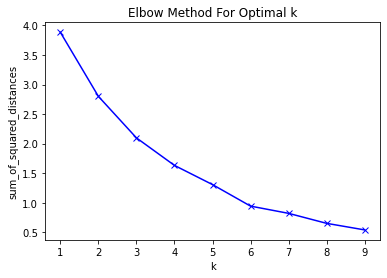

In [55]:
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('Elbow Method For Optimal k');

#### Modelling (K-Means Machine Learning algorithm)

In [56]:
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Newham_grouped_clustering)

# check cluster labels generated for each row in the dataframe
labels = kmeans.labels_
labels

array([3, 0, 0, 3, 1, 0, 0, 2, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0])

In [57]:
Newham_merged = Newham_neighborhood

Newham_merged['Cluster Labels'] = kmeans.labels_

# merge Newham_grouped with Newham_data to add latitude/longitude for each neighborhood
Newham_merged= Newham_merged.join(neighborhoods_venues_sorted.set_index('District'), on='District')

Newham_merged.head()

,District,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Beckton,Newham,51.516080,0.059426,3,Coffee Shop,Café,American Restaurant,Portuguese Restaurant,Indian Restaurant,Italian Restaurant,Latin American Restaurant,Lebanese Restaurant,Mediterranean Restaurant,Mexican Restaurant
1,Canning Town,Newham,51.513989,0.008299,0,Coffee Shop,Café,Sandwich Place,Fast Food Restaurant,Italian Restaurant,English Restaurant,Turkish Restaurant,Food & Drink Shop,Diner,Pizza Place
2,Custom House,Newham,51.509597,0.028292,0,Coffee Shop,Café,Chinese Restaurant,Sandwich Place,Tapas Restaurant,Restaurant,Asian Restaurant,Lebanese Restaurant,Middle Eastern Restaurant,Salad Place
3,Cyprus,Newham,51.508478,0.063969,3,Coffee Shop,American Restaurant,Portuguese Restaurant,Indian Restaurant,Italian Restaurant,Latin American Restaurant,Lebanese Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant
4,East Ham,Newham,51.532963,0.055320,1,Fast Food Restaurant,Indian Restaurant,Pizza Place,Café,Coffee Shop,Sandwich Place,Italian Restaurant,Latin American Restaurant,Lebanese Restaurant,Mediterranean Restaurant


## 4. Results

In [58]:
address = 'Newham,London,United Kingdom '

geolocator = Nominatim(user_agent="Newham_explorer", timeout=3)
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Newham are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Newham are 51.52999955, 0.02931796029382208.


In [59]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(6)
ys = [i + x + (i*x)**2 for i in range(6)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Newham_merged['Latitude'], Newham_merged['Longitude'], Newham_merged['District'], Newham_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
        
map_clusters

In [60]:
required_column_indices = [0,5,6]
required_column = [list(Newham_merged.columns.values)[i] for i in required_column_indices]
required_column_indices = [0,5,6]

In [61]:
cluster_0 = Newham_merged.loc[Newham_merged['Cluster Labels'] == 0, Newham_merged.columns[0:15]]
cluster_0

,District,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Canning Town,Newham,51.513989,0.008299,0,Coffee Shop,Café,Sandwich Place,Fast Food Restaurant,Italian Restaurant,English Restaurant,Turkish Restaurant,Food & Drink Shop,Diner,Pizza Place
2,Custom House,Newham,51.509597,0.028292,0,Coffee Shop,Café,Chinese Restaurant,Sandwich Place,Tapas Restaurant,Restaurant,Asian Restaurant,Lebanese Restaurant,Middle Eastern Restaurant,Salad Place
5,East Village,Newham,51.548108,-0.009177,0,Café,Italian Restaurant,Vegetarian / Vegan Restaurant,Dessert Shop,Mexican Restaurant,Modern European Restaurant,Fish & Chips Shop,Eastern European Restaurant,Sandwich Place,Ice Cream Shop
6,Forest Gate,Newham,51.549524,0.024925,0,Fast Food Restaurant,Restaurant,Asian Restaurant,Café,Comfort Food Restaurant,Ice Cream Shop,Pizza Place,Italian Restaurant,Latin American Restaurant,Lebanese Restaurant
9,Mill Meads,Newham,51.530370,-0.003497,0,Café,Breakfast Spot,Thai Restaurant,Street Food Gathering,Fish & Chips Shop,American Restaurant,Pizza Place,Italian Restaurant,Latin American Restaurant,Lebanese Restaurant
10,North Woolwich,Newham,51.500407,0.064154,0,Sandwich Place,Italian Restaurant,Breakfast Spot,Café,Chinese Restaurant,Coffee Shop,Portuguese Restaurant,Latin American Restaurant,Lebanese Restaurant,Mediterranean Restaurant
11,Plaistow,Newham,51.531154,0.016683,0,Asian Restaurant,Café,Breakfast Spot,Bulgarian Restaurant,Fish & Chips Shop,American Restaurant,Portuguese Restaurant,Latin American Restaurant,Lebanese Restaurant,Mediterranean Restaurant
12,Plashet,Newham,51.540008,0.039274,0,Indian Restaurant,Fast Food Restaurant,Sandwich Place,Asian Restaurant,Ice Cream Shop,Modern European Restaurant,Italian Restaurant,Latin American Restaurant,Lebanese Restaurant,Mediterranean Restaurant
14,Stratford,Newham,51.541289,-0.003547,0,Café,Coffee Shop,Italian Restaurant,Thai Restaurant,Ice Cream Shop,Sandwich Place,Burger Joint,Pizza Place,Frozen Yogurt Shop,Mexican Restaurant
15,Stratford Marsh,Newham,51.539325,-0.009594,0,Café,Restaurant,Pizza Place,Thai Restaurant,Sandwich Place,Burger Joint,Ice Cream Shop,Coffee Shop,Italian Restaurant,Mediterranean Restaurant


In [62]:
for col in required_column:
    print(cluster_0[col].value_counts(ascending = False))
    print("---------------------------------------------")

Forest Gate           1
Stratford New Town    1
Mill Meads            1
Custom House          1
East Village          1
North Woolwich        1
Upton                 1
Plaistow              1
Temple Mills          1
Upton Park            1
Stratford Marsh       1
Canning Town          1
West Ham              1
Plashet               1
Wallend               1
Stratford             1
Name: District, dtype: int64
---------------------------------------------
Café                    6
Fast Food Restaurant    3
Coffee Shop             3
Asian Restaurant        2
Indian Restaurant       1
Sandwich Place          1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Café                    6
Restaurant              2
Italian Restaurant      2
Pizza Place             1
Breakfast Spot          1
Indian Restaurant       1
Fast Food Restaurant    1
Asian Restaurant        1
Coffee Shop             1
Name: 2nd Most Common Venue, dtype: int64
---------------------

In [63]:
cluster_1 = Newham_merged.loc[Newham_merged['Cluster Labels'] == 1, Newham_merged.columns[0:15]]
cluster_1

,District,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,East Ham,Newham,51.532963,0.055320,1,Fast Food Restaurant,Indian Restaurant,Pizza Place,Café,Coffee Shop,Sandwich Place,Italian Restaurant,Latin American Restaurant,Lebanese Restaurant,Mediterranean Restaurant
8,Maryland,Newham,51.546053,0.005922,1,Pizza Place,Café,Coffee Shop,Indian Restaurant,Burger Joint,Frozen Yogurt Shop,Eastern European Restaurant,Italian Restaurant,Portuguese Restaurant,Food Court
13,Silvertown,Newham,51.501363,0.038518,1,Coffee Shop,Sandwich Place,Restaurant,American Restaurant,Asian Restaurant,Taxi Stand,Salad Place,Pizza Place,Mexican Restaurant,Italian Restaurant
21,Manor Park,Newham,51.550330,0.048580,1,Indian Restaurant,Restaurant,American Restaurant,Pizza Place,Ice Cream Shop,Italian Restaurant,Latin American Restaurant,Lebanese Restaurant,Mediterranean Restaurant,Mexican Restaurant


In [64]:
for col in required_column:
    print(cluster_1[col].value_counts(ascending = False))
    print("---------------------------------------------")

Silvertown    1
Manor Park    1
East Ham      1
Maryland      1
Name: District, dtype: int64
---------------------------------------------
Pizza Place             1
Fast Food Restaurant    1
Indian Restaurant       1
Coffee Shop             1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Restaurant           1
Café                 1
Indian Restaurant    1
Sandwich Place       1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------


In [65]:
cluster_2 = Newham_merged.loc[Newham_merged['Cluster Labels'] == 2, Newham_merged.columns[0:15]]
cluster_2

,District,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Little Ilford,Newham,51.550298,0.062522,2,Ice Cream Shop,Restaurant,American Restaurant,Pizza Place,Indian Restaurant,Italian Restaurant,Latin American Restaurant,Lebanese Restaurant,Mediterranean Restaurant,Mexican Restaurant


In [66]:
for col in required_column:
    print(cluster_2[col].value_counts(ascending = False))
    print("---------------------------------------------")

Little Ilford    1
Name: District, dtype: int64
---------------------------------------------
Ice Cream Shop    1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Restaurant    1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------


In [67]:
cluster_3 = Newham_merged.loc[Newham_merged['Cluster Labels'] == 3, Newham_merged.columns[0:15]]
cluster_3

,District,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Beckton,Newham,51.516080,0.059426,3,Coffee Shop,Café,American Restaurant,Portuguese Restaurant,Indian Restaurant,Italian Restaurant,Latin American Restaurant,Lebanese Restaurant,Mediterranean Restaurant,Mexican Restaurant
3,Cyprus,Newham,51.508478,0.063969,3,Coffee Shop,American Restaurant,Portuguese Restaurant,Indian Restaurant,Italian Restaurant,Latin American Restaurant,Lebanese Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant


In [68]:
for col in required_column:
    print(cluster_3[col].value_counts(ascending = False))
    print("---------------------------------------------")

Beckton    1
Cyprus     1
Name: District, dtype: int64
---------------------------------------------
Coffee Shop    2
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
American Restaurant    1
Café                   1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------


## 5. Discussion

Due to diversity of the Newham in each neighbourhood there is an assortment of most common venues and there are numerous ethnic restaurants as well. Our analysis is focused on finding optimal neighbourhood for opening Asian restaurant so to understand the clusters let us find out which neighbourhood has most common venues related to Asian ethnicity. From cluster 0, Custom House, Plashet, Upton Park, Upton, Silvertown are the neighbourhoods with the highest number of Asian restaurants. In cluster 1, Indian Restaurant is most common across all the neighbourhoods and these are not crowded with other Asian cuisines. Cluster 2 is not famous for Asian cuisine hence opening an Asian restaurant in these neighbourhoods will not be profitable. In Cluster 3 Forest Gate and Wallend has Asian restaurant in top 2 most common venue.

## 6. Conclusion

One application of Clustering Algorithm, k-Means or others, to a multi-dimensional dataset, a very inquisitive result can be curated which helps to understand and visualize the data. The neighbourhoods of Newham borough are very briefly segmented into four clusters based on most common venue hence when looking for a restaurant location, one must consider who else is doing business in the neighbourhood. If there are already many restaurants with the same concept of ethnic cooking, then it will not be a profitable deal to choose that location such neighbourhoods are mostly appearing in cluster 0. While neighbourhoods in cluster 1 are most common for Asian ethnic venue but at the same time less crowded with Asian restaurants. To enjoy maximum patrons in the restaurant, the neighbourhoods from cluster 1 are assumed best choice to open Asian restaurant. The results of this project can be improved and made more inquisitive by considering neighbourhoods of other boroughs which has high proportion of Asian population. The scope of this project can be expanded further to choose best borough for opening Asian or other ethnic concept restaurants and suggest a new vendor a profitable location in diverse city like London.